In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

In [3]:
SEED = 3264602 # from random.org

In [8]:
'''
    SELECT 
      st_x(calls_geom.geom) x, st_y(calls_geom.geom) y
      --, st_x(calls_geom.pickup_geom) pickup_x, st_y(calls_geom.pickup_geom) pickup_y
    FROM taxi.calls_geom
      join calls on calls_geom.id = calls.id
      join dispatch_results on calls_geom.id = dispatch_results.call_id
    WHERE
      calls_geom.geom && ST_MakeEnvelope(202144,202656,444133,444366, 5181)
      and dispatch_results.status = 10
      and calls.created_at between '20171101000000' and '20171201000000'
      and origin_name = '강남역 2호선 9번출구'
'''
x = np.loadtxt('one_origin_name.csv', delimiter=',')

In [9]:
x[:5]

array([[ 202367.746471,  444284.581821],
       [ 202367.940635,  444261.186464],
       [ 202367.940635,  444261.186464],
       [ 202361.509487,  444274.998531],
       [ 202374.977612,  444259.082173]])

In [10]:
mean = x.mean(axis=0)
x = x-mean
x[:5]

array([[ -4.32805665,  18.02979331],
       [ -4.13389265,  -5.36556369],
       [ -4.13389265,  -5.36556369],
       [-10.56504065,   8.44650331],
       [  2.90308435,  -7.46985469]])

In [11]:
print(x.shape)
print(x.mean(axis=0).shape)

(798, 2)
(2,)


In [12]:
with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., sd_dist=pm.HalfCauchy.dist(2.5))

In [13]:
with model:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = pm.Deterministic('Σ', L.dot(L.T))

In [14]:
with model:
    μ = pm.Normal('μ', 0., 10., shape=2, testval=x.mean(axis=0))
    obs = pm.MvNormal('obs', μ, chol=L, observed=x)

In [15]:
with model:
    trace = pm.sample(random_seed=SEED, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:07<00:00, 138.77it/s]


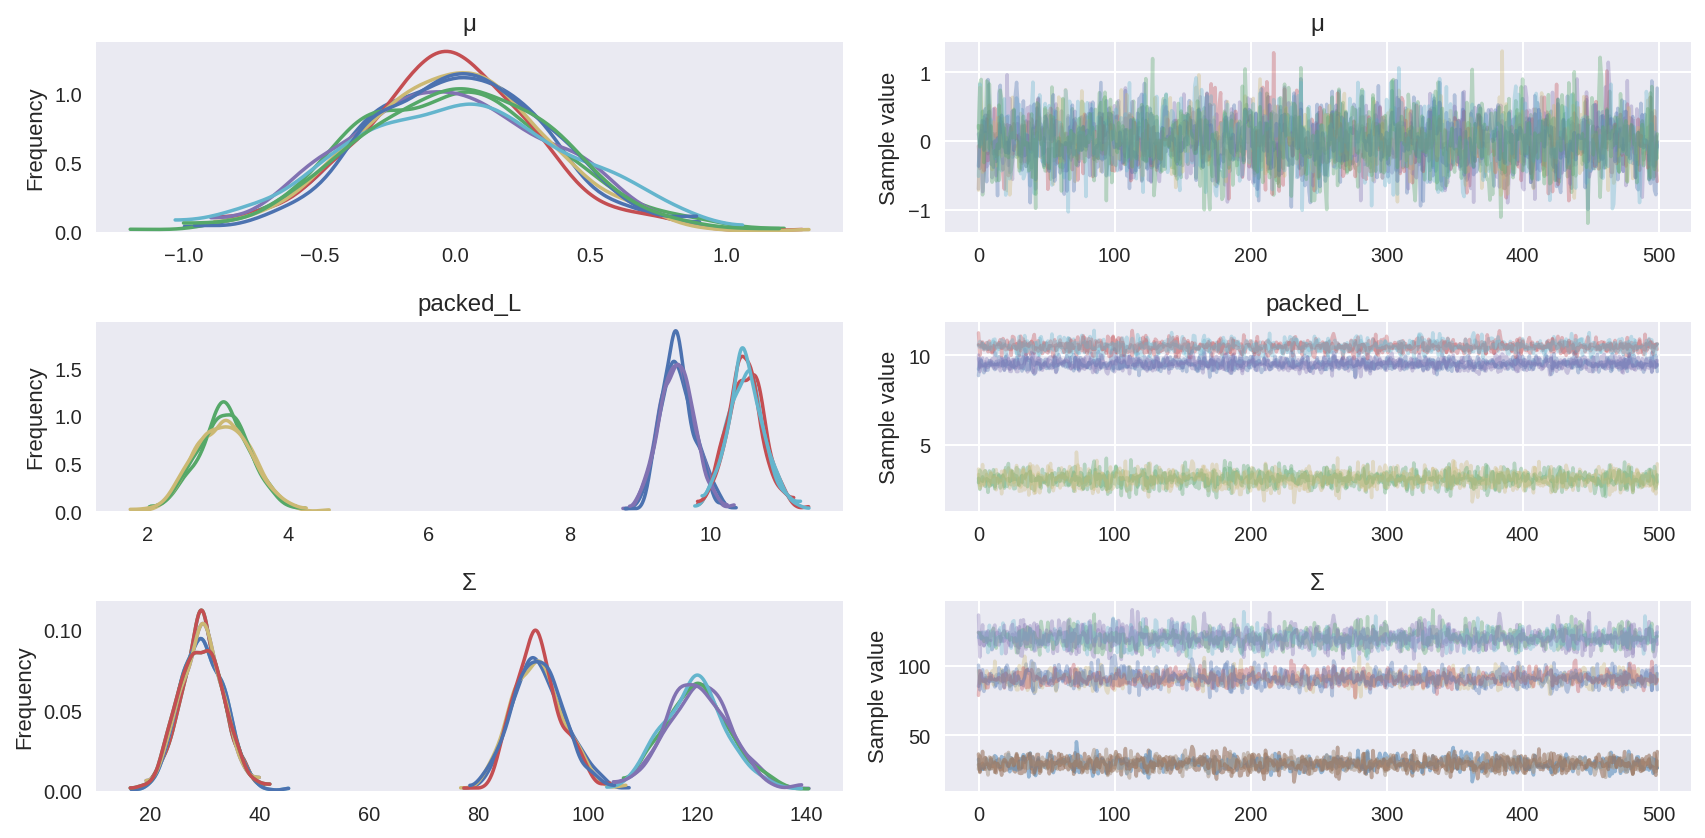

In [16]:
pm.traceplot(trace);

In [17]:
μ_post = trace['μ'].mean(axis=0)
Σ_post = trace['Σ'].mean(axis=0)

In [18]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180. / np.pi * np.arccos(np.abs(U_post[0, 0]))

In [19]:
var_post

array([  72.69882258,  138.28089993])

In [20]:
confidence = 5.991 # 95%
#confidence = 9.210 # 99%
#confidence = 4.605 # 90%
# http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/

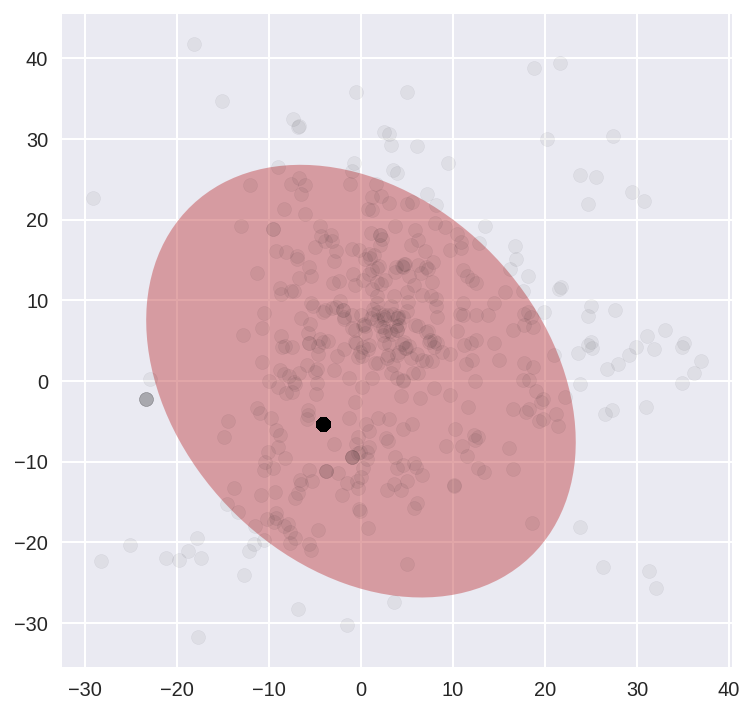

In [21]:
blue, _, red, *_ = sns.color_palette()
fig, ax = plt.subplots(figsize=(6, 6))

e_post = Ellipse(μ_post, 
                 2 * np.sqrt(confidence * var_post[0]),
                 2 * np.sqrt(confidence * var_post[1]),
                 angle=angle_post)
e_post.set_alpha(0.5)
e_post.set_facecolor(red)
e_post.set_zorder(10);
ax.add_artist(e_post);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.05, zorder=11);

In [22]:
help(Ellipse)

Help on class Ellipse in module matplotlib.patches:

class Ellipse(Patch)
 |  A scale-free ellipse.
 |  
 |  Method resolution order:
 |      Ellipse
 |      Patch
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, xy, width, height, angle=0.0, **kwargs)
 |      *xy*
 |        center of ellipse
 |      
 |      *width*
 |        total length (diameter) of horizontal axis
 |      
 |      *height*
 |        total length (diameter) of vertical axis
 |      
 |      *angle*
 |        rotation in degrees (anti-clockwise)
 |      
 |      Valid kwargs are:
 |        agg_filter: unknown
 |        alpha: float or None 
 |        animated: [True | False] 
 |        antialiased or aa: [True | False]  or None for default 
 |        axes: an :class:`~matplotlib.axes.Axes` instance 
 |        capstyle: ['butt' | 'round' | 'projecting'] 
 |        clip_box: a :class:`matplotlib.transforms.Bbox` instance 
 |        clip_on: [True | False] 

In [25]:
e_post.get_transform()

CompositeGenericTransform(Affine2D(array([[  1.77349094e+01,  -1.51715857e+01,  -5.89852925e-03],
       [  1.10005288e+01,   2.44594329e+01,  -3.51439751e-03],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])), CompositeGenericTransform(TransformWrapper(BlendedAffine2D(IdentityTransform(),IdentityTransform())), CompositeGenericTransform(BboxTransformFrom(TransformedBbox(Bbox([[-32.46418975104901, -35.39186160936499], [40.298304454195055, 45.47848823579972]]), TransformWrapper(BlendedAffine2D(IdentityTransform(),IdentityTransform())))), BboxTransformTo(TransformedBbox(Bbox([[0.125, 0.125], [0.9, 0.88]]), BboxTransformTo(TransformedBbox(Bbox([[0.0, 0.0], [6.0, 6.0]]), Affine2D(array([[ 72.,   0.,   0.],
       [  0.,  72.,   0.],
       [  0.,   0.,   1.]])))))))))